In [1]:
import torch
import timm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torch.nn import *
from csvlogger import CSVLogger
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from tqdm import tqdm


In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# device = 'cpu'
print(f"Device: {device}")

Device: cuda


In [4]:
print(os.listdir('Binary_ttv\\src')) # Preliminary Image Processing\Alzheimer_s Dataset_binary\src
print(os.listdir('Binary_ttv\\train'))
print(os.listdir('Binary_ttv\\test'))
print(os.listdir('Binary_ttv\\val'))

['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']
['Demented', 'NonDemented']


Modified Test Loader

In [5]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
test_dataset2 = ImageFolder(root='Binary_TTV_over_under_all\\test', transform=transform)

batch_size = 26  # Adjust as needed
num_workers = 4  # Number of subprocesses to use for data loading
pin_memory = True  # Whether to use pinned memory for faster data transfer to GPU

test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(test_loader2))
print(len(test_dataset2))

499
12964


New Train Loader

In [6]:
# # Define transformations for image preprocessing
# transform = transforms.Compose([
#     transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
#     transforms.ToTensor(),           # Convert images to tensors
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
# ])

# # Load training and testing datasets
# train_dataset = ImageFolder(root='Binary_ttv\\train', transform=transform)
# test_dataset = ImageFolder(root='Binary_ttv\\test', transform=transform)
# val_dataset = ImageFolder(root='Binary_ttv\\val', transform=transform)

# batch_size = 26  # Adjust as needed
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# print(len(train_loader))
# print(len(test_loader))
# print(len(val_loader))
# print(len(train_dataset))
# print(len(test_dataset))
# print(len(val_dataset))

# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((176, 208)),  # Resize images to a common size (adjust as needed)
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # Normalize using ImageNet stats
])

# Load training and testing datasets
train_dataset = ImageFolder(root='Binary_TTV_over_under_train\\train', transform=transform)
test_dataset = ImageFolder(root='Binary_TTV_over_under_train\\test', transform=transform)
val_dataset = ImageFolder(root='Binary_TTV_over_under_train\\val', transform=transform)

batch_size = 26  # Adjust as needed
num_workers = 4  # Number of subprocesses to use for data loading
pin_memory = True  # Whether to use pinned memory for faster data transfer to GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

print(len(train_loader))
print(len(test_loader))
print(len(val_loader))
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

2328
499
499
60510
12965
12967


In [7]:
learning_rate = 0.0001
epochs = 100
patience = 5

Model architecture definition


In [11]:
model = Sequential(
    # Convolutional layers
    Conv2d(3, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),

    # Additional layer added
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    # Fully connected layers
    Flatten(),
    Linear(32 * 44 * 52, 150),  # Adjust the input size based on your image dimensions
    ReLU(),
    Dropout(0.2),
    Linear(150, 1),  # Output layer with one neuron and sigmoid activation
    Sigmoid()
).to(device)

In [12]:
# Loss and optimizer
loss_value = BCELoss()  # Binary Cross Entropy Loss for binary classification
# loss_value = BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
model_opt = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# Logging
losslogger = CSVLogger('new_custom_model_loss.csv', fieldnames=["datetime", "batch", "epoch", "train_loss", "val_loss", "val_accuracy"])
acclogger = CSVLogger('new_custom_model_acc.csv', fieldnames=["datetime", "average_accuracy"])

# Training loop
num_epochs = epochs
early_stopping = False
best_loss = float('inf')
counter = 0

print(f"Device: {device}")
print(f"Start time: {datetime.datetime.now()}")
print(f"Number of epochs: {num_epochs}")

for epoch in range(num_epochs):
    model.train()  
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    # Training
    for batch_idx, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.float().to(device)
        model_opt.zero_grad()
        outputs = model(inputs)
        loss = loss_value(outputs, labels.unsqueeze(1))
        loss.backward()
        model_opt.step()
        counter += 1

        # Update tqdm progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    
    pbar.close()
    
    # Validation
    model.eval()  
    total = 0
    correct = 0
    val_loss = 0.0
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.float().to(device)
        val_outputs = model(val_inputs)
        val_loss += loss_value(val_outputs, val_labels.unsqueeze(1)).item()
        predicted = (val_outputs > 0.5).float()
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    losslog_data = {"datetime": datetime.datetime.now(), "batch": batch_size, "epoch": epoch+1, "train_loss": loss.item(), "val_loss": val_loss, "val_accuracy": val_accuracy}
    losslogger.log(losslog_data)

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  
    else:
        patience_counter += 1  
        
        # If validation loss hasn't improved for 'patience' epochs, stop early
        if patience_counter >= patience:
            print("Early stopping triggered")
            early_stopping = True
            break
    
    if early_stopping:
        break
    
    print(f"Completed epoch {epoch + 1} with loss {loss.item()}, validation loss {val_loss}")


# Testing
correct = 0
total = 0
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.float().to(device)
        outputs = model(inputs)
        predicted = (outputs > 0.5).float()
        # _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Save model
torch.save(model.state_dict(), 'Models/new_custom_model.pth')


Device: cuda
Start time: 2023-11-14 21:23:33.202784
Number of epochs: 100


100%|██████████| 2328/2328 [01:10<00:00, 32.95it/s, Loss=0.0310]


Completed epoch 1 with loss 0.0309734083712101, validation loss 0.13123851897904673


100%|██████████| 2328/2328 [01:09<00:00, 33.73it/s, Loss=0.0027]


Completed epoch 2 with loss 0.0026944419369101524, validation loss 0.03305072862930527


100%|██████████| 2328/2328 [01:05<00:00, 35.33it/s, Loss=0.0006]


Completed epoch 3 with loss 0.0006064251647330821, validation loss 0.03224394147380157


100%|██████████| 2328/2328 [01:11<00:00, 32.74it/s, Loss=0.0000]


Completed epoch 4 with loss 2.0009740637760842e-06, validation loss 0.015217134147533


100%|██████████| 2328/2328 [01:11<00:00, 32.57it/s, Loss=0.0000]


Completed epoch 5 with loss 3.653737439890392e-05, validation loss 0.005813841475804304


100%|██████████| 2328/2328 [01:11<00:00, 32.73it/s, Loss=0.0000]


Completed epoch 6 with loss 1.8889389821197256e-06, validation loss 0.002748544733515672


100%|██████████| 2328/2328 [01:05<00:00, 35.39it/s, Loss=0.0000]


Completed epoch 7 with loss 1.86197976290714e-05, validation loss 0.0033183324973862743


100%|██████████| 2328/2328 [01:04<00:00, 36.01it/s, Loss=0.0029]


Completed epoch 8 with loss 0.0029274141415953636, validation loss 0.003815014185837535


100%|██████████| 2328/2328 [01:06<00:00, 35.04it/s, Loss=0.0001]


Completed epoch 9 with loss 0.00011923773126909509, validation loss 0.0015706185410752766


100%|██████████| 2328/2328 [01:05<00:00, 35.68it/s, Loss=0.0001]


Completed epoch 10 with loss 7.863980863476172e-05, validation loss 0.0030397476169917647


100%|██████████| 2328/2328 [01:10<00:00, 32.98it/s, Loss=0.0001]


Completed epoch 11 with loss 7.655768422409892e-05, validation loss 0.0025919122398542086


100%|██████████| 2328/2328 [01:09<00:00, 33.27it/s, Loss=0.0000]


Completed epoch 12 with loss 1.919406031447579e-06, validation loss 0.0017421859892595701


100%|██████████| 2328/2328 [01:08<00:00, 33.82it/s, Loss=0.0002]


Completed epoch 13 with loss 0.00015679506759624928, validation loss 0.0009426386099469691


100%|██████████| 2328/2328 [01:08<00:00, 34.16it/s, Loss=0.0033]


Completed epoch 14 with loss 0.003327056299895048, validation loss 0.0027638699082441404


100%|██████████| 2328/2328 [01:07<00:00, 34.33it/s, Loss=0.0000]


Completed epoch 15 with loss 1.4048265256860759e-05, validation loss 0.002476916311957467


100%|██████████| 2328/2328 [01:08<00:00, 34.15it/s, Loss=0.0000]


Completed epoch 16 with loss 1.0684403605409898e-05, validation loss 0.0005162254822212085


100%|██████████| 2328/2328 [01:06<00:00, 35.00it/s, Loss=0.0000]


Completed epoch 17 with loss 3.107072643615538e-07, validation loss 0.0007816258364206578


100%|██████████| 2328/2328 [01:07<00:00, 34.41it/s, Loss=0.0000]


Completed epoch 18 with loss 1.490415684202162e-07, validation loss 0.0009687792339179631


100%|██████████| 2328/2328 [01:08<00:00, 34.19it/s, Loss=0.0000]


Completed epoch 19 with loss 4.186677324469201e-05, validation loss 0.003801571629122837


100%|██████████| 2328/2328 [01:07<00:00, 34.39it/s, Loss=0.0004]


Completed epoch 20 with loss 0.000368903623893857, validation loss 0.010028785358861238


100%|██████████| 2328/2328 [01:07<00:00, 34.24it/s, Loss=0.0006]


Early stopping triggered


Accuracy on the test dataset: 2596.058619%



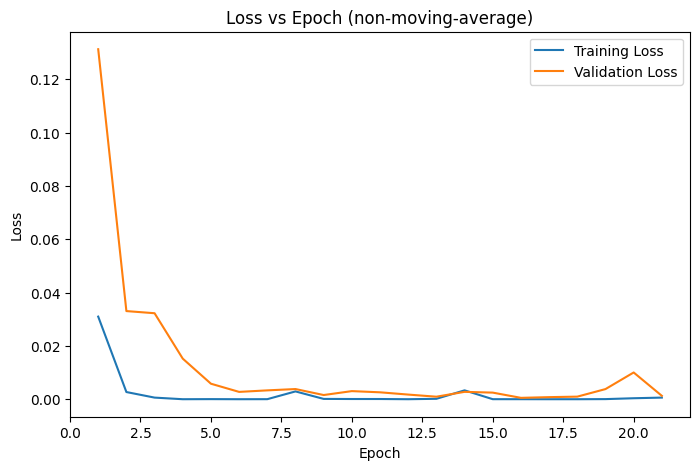

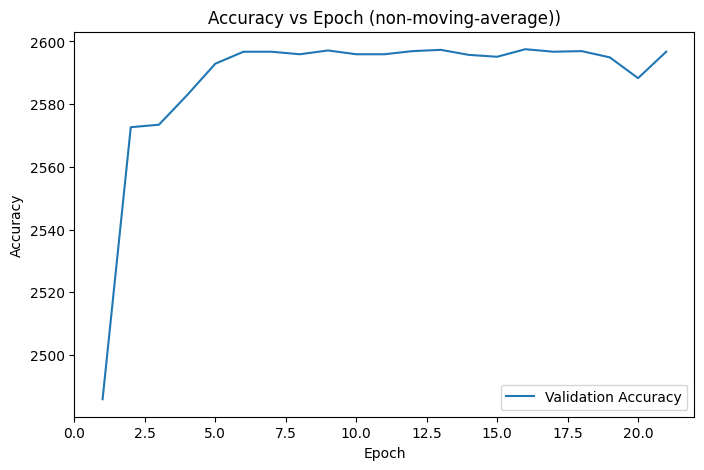

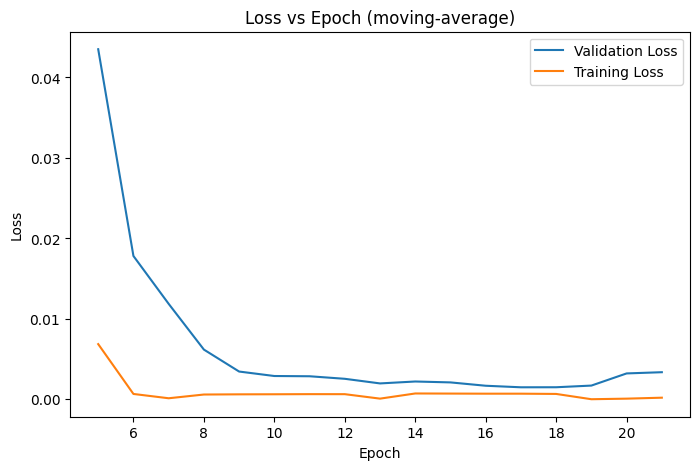

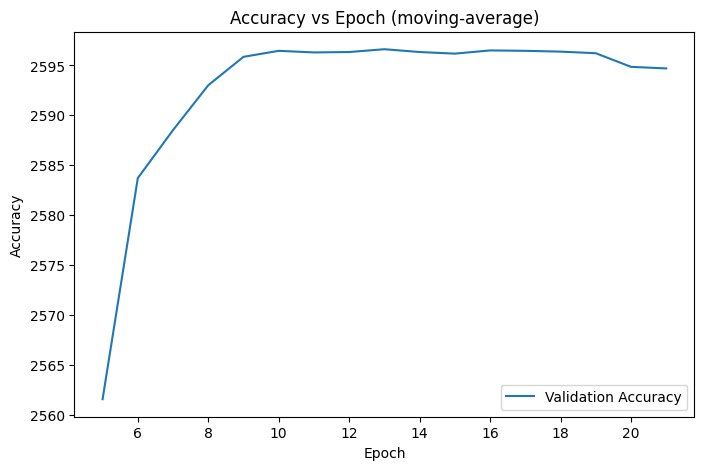

In [13]:
lossdf = pd.read_csv("new_custom_model_loss.csv", engine="pyarrow")
rolling_mean = lossdf["val_loss"].rolling(window=5).mean()
rolling_mean2 = lossdf["train_loss"].rolling(window=5).mean()
rolling_mean3 = lossdf["val_accuracy"].rolling(window=5).mean()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["train_loss"], label="Training Loss")
plt.plot(lossdf["epoch"], lossdf["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (non-moving-average)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], lossdf["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (non-moving-average))")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean, label="Validation Loss")
plt.plot(lossdf["epoch"], rolling_mean2, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch (moving-average)")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(lossdf["epoch"], rolling_mean3, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch (moving-average)")
plt.legend()
plt.show()




Accuracy on the test dataset: 2596.058619%

Confusion Matrix:
 [[ 2875     7]
 [    0 10083]]


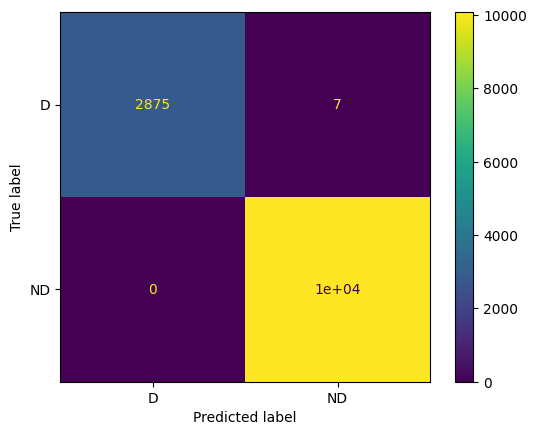


Manual Precision: 0.9993062438057483
Manual Recall: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2882
         1.0       1.00      1.00      1.00     10083

    accuracy                           1.00     12965
   macro avg       1.00      1.00      1.00     12965
weighted avg       1.00      1.00      1.00     12965



AUC-ROC Score: 0.998786


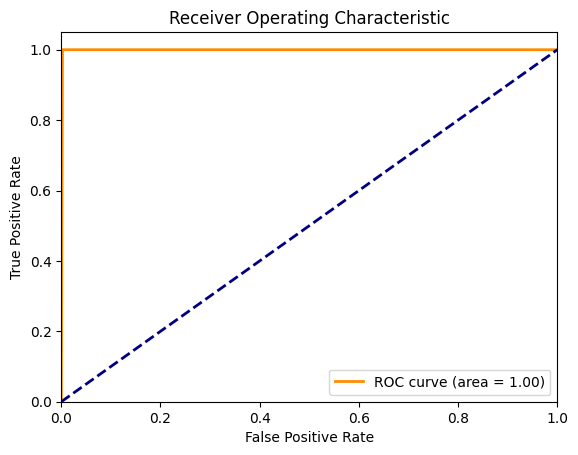

In [14]:
import torch
import timm
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score, precision_score, recall_score, ConfusionMatrixDisplay

accuracy = 100 * correct / total
acclog_data = {"datetime": datetime.datetime.now(), "average_accuracy": accuracy}
acclogger.log(acclog_data)
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Bigger testing

In [15]:
model = Sequential(
    # Convolutional layers
    Conv2d(3, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    Conv2d(32, 32, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    
    # Fully connected layers
    Flatten(),
    Linear(32 * 44 * 52, 150),  # Adjust the input size based on your image dimensions
    ReLU(),
    Dropout(0.2),
    Linear(150, 1),  # Output layer with one neuron and sigmoid activation
    Sigmoid()
).to(device)

In [16]:

# # Import the timm pth models
# model = torch.load("mobilenetv3_large.pth")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load the saved state dictionary into the model
model.load_state_dict(torch.load('Models/new_custom_model.pth', map_location=device))

correct = 0
total = 0
all_predicted = []
all_labels = []
counter = 0

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_loader2:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        counter += 1
        if counter % 5000 == 0:
            print(f"Completed {counter} batches")

accuracy = 100 * correct / total

print("Done testing")



Device: cuda
Done testing




Accuracy on the test dataset: 50.000000%

Confusion Matrix:
 [[6482    0]
 [6482    0]]


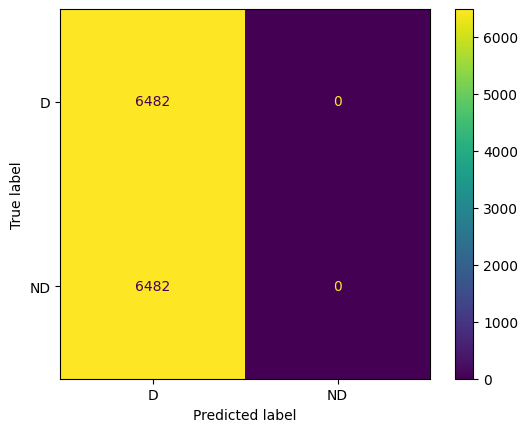


Manual Precision: 0.0
Manual Recall: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      6482
           1       0.00      0.00      0.00      6482

    accuracy                           0.50     12964
   macro avg       0.25      0.50      0.33     12964
weighted avg       0.25      0.50      0.33     12964



AUC-ROC Score: 0.500000


c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\envs\DementiaGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hifia\anaconda3\

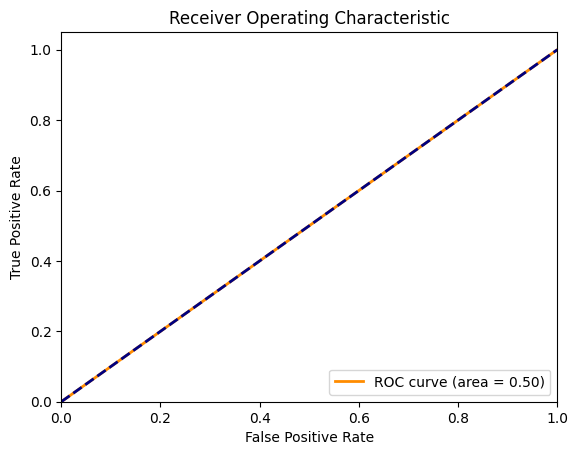

In [18]:
print('\n\nAccuracy on the test dataset: {:.6f}%'.format(accuracy), end="\n\n")

# Calculate the confusion matrix
confusion = confusion_matrix(all_labels, all_predicted)
print("Confusion Matrix:\n", confusion)
cm = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=["D", "ND"])
cm.plot()
plt.show()
print(cm, end='\n\n')

# Generate precision-recall metrics
precision_manual = precision_score(all_labels, all_predicted)
recall_manual = recall_score(all_labels, all_predicted)

print("Manual Precision:", precision_manual)
print("Manual Recall:", recall_manual, end="\n\n")

# Generate classification report
report = classification_report(all_labels, all_predicted)
print("Classification Report:\n", report, end='\n\n')

# Calculate ROC curve and AUC-ROC score
# fpr, tpr, thresholds = roc_curve(all_labels, outputs.cpu().numpy()[:, 1].astype(float))
fpr, tpr, thresholds = roc_curve(y_true=all_labels, y_score=all_predicted)
roc_auc = auc(fpr, tpr)
print("\nAUC-ROC Score: {:.6f}".format(roc_auc))

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()